In [87]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler, UNet2DModel

In [88]:
#@title Hyperparameters & device

BATCH_SIZE = 128
NUM_EPOCHS = 10
T = 100 # Timesteps
IMG_SIZE = 32
LR = 1e-3 # Learning rate
UNET_EXP = 6 # Exponent of unet (8 -> 16, ...)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


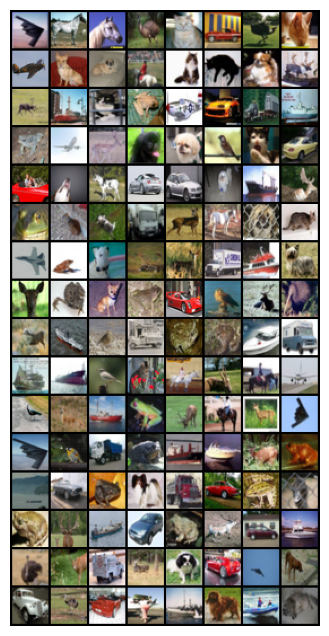

In [89]:
#@title MNIST Dataset

dataset = torchvision.datasets.CIFAR10(root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

x, y = next(iter(train_dataloader))

# Create a grid of images
grid = torchvision.utils.make_grid(x)
# Convert the grid to a numpy image
npimg = grid.permute(1, 2, 0).cpu().numpy()

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis('off')
plt.show()


In [90]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

# Model

In [91]:
#@title Create model with input, output channels

# Create the network
net = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=4,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=LR) 

# Keeping a record of the losses for later viewing
losses = []

sched = DDPMScheduler(T, prediction_type="sample")

num_of_params = sum([p.numel() for p in net.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# The training loop
for epoch in range(NUM_EPOCHS):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')


Number of trainable parameters in the model: 2,795,971
Finished epoch 0. Average loss for this epoch: 0.029663
Finished epoch 1. Average loss for this epoch: 0.019072
Finished epoch 2. Average loss for this epoch: 0.017436
Finished epoch 3. Average loss for this epoch: 0.016107
Finished epoch 4. Average loss for this epoch: 0.014815
Finished epoch 5. Average loss for this epoch: 0.014710
Finished epoch 6. Average loss for this epoch: 0.014403
Finished epoch 7. Average loss for this epoch: 0.013923
Finished epoch 8. Average loss for this epoch: 0.013687
Finished epoch 9. Average loss for this epoch: 0.013644


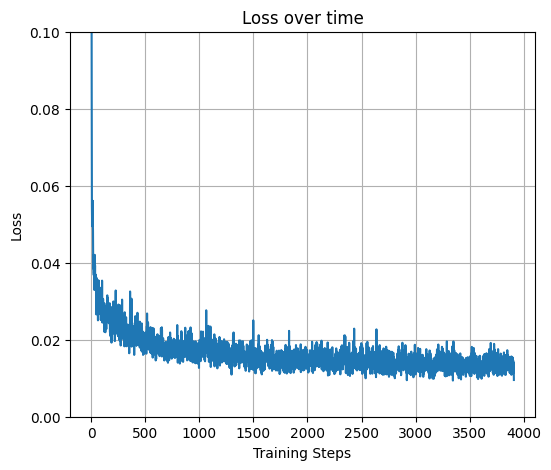

In [92]:
plt.figure(figsize=(6, 5))
plt.plot(losses)
plt.ylim(0, 0.1)
plt.title('Loss over time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

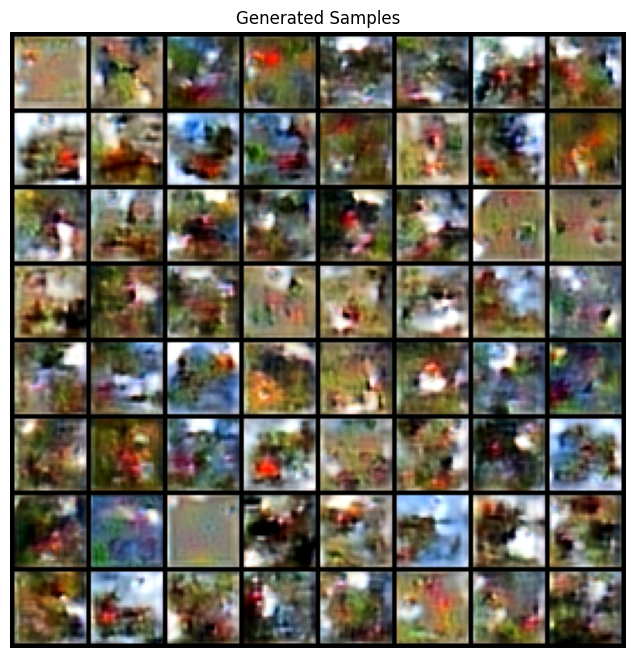

In [93]:
# Generate samples
n_steps = 40
x = torch.rand(64, 3, 32, 32).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i) if (n_steps-i) != 0 else 1
  x = x*(1-mix_factor) + pred*mix_factor

# Detach from the computation graph and move to CPU for plotting
x = x.detach().cpu()

# Create a grid of images
# We use permute to change the tensor shape from (C, H, W) to (H, W, C) for displaying
grid = torchvision.utils.make_grid(x, nrow=8).clip(0, 1)
grid = rearrange(grid, "c h w -> h w c")

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.title('Generated Samples')
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

In [98]:
#@title Save the model

path = "trained_model.pt"
torch.save(net, path)

In [99]:
#@title Load model

path = "trained_model.pt"
model = torch.load(path, weights_only=False)
model.to(device)
model.eval()
print("OK")

OK


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4831605..3.2989798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53037506..0.58655477].


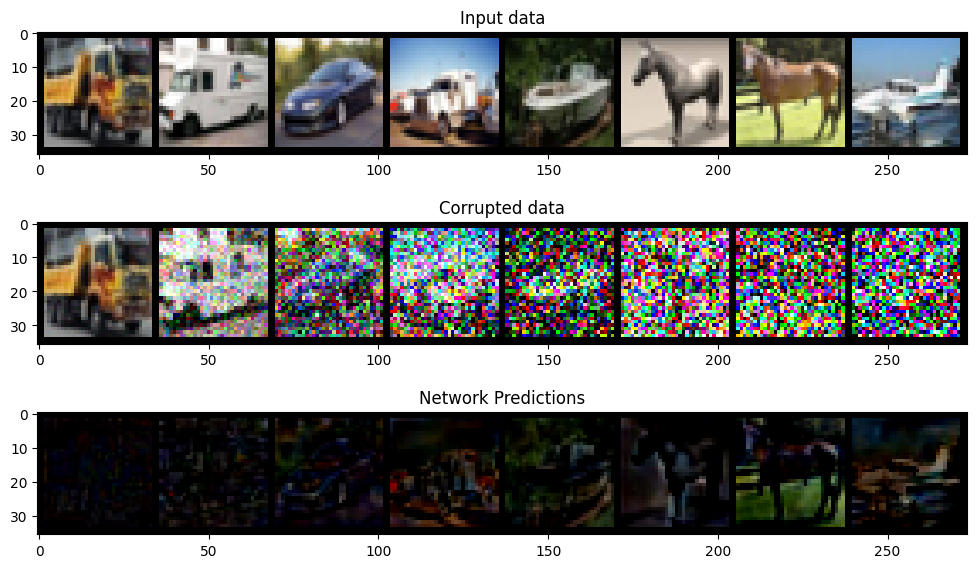

In [96]:
#@title Sampling

# Fetch some data
x, y = next(iter(train_dataloader))
batch_size = 8
x = x[:batch_size] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
t = torch.linspace(0, T-1, batch_size).long().to(device)
noise = torch.randn_like(x).to(device)
x = x.to(device)
noisy_x = sched.add_noise(x, noise, t).to(device)

# Get the model predictions
with torch.no_grad():
    preds = model(noisy_x, t).sample.detach().cpu()
    x = x.detach().cpu()
    minus = x - preds

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
grid = torchvision.utils.make_grid(x) # Create a grid of images
npimg = grid.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[0].imshow(npimg)

axs[1].set_title('Corrupted data')
grid2 = torchvision.utils.make_grid(noisy_x) # Create a grid of images
npimg2 = grid2.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[1].imshow(npimg2)

axs[2].set_title('Network Predictions')
grid3 = torchvision.utils.make_grid(minus) # Create a grid of images
npimg3 = grid3.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[2].imshow(npimg3)